Cifar10 dataset split into neg/pos and trained using normal CNN without augmentation. With ds resampling (see https://www.tensorflow.org/guide/data#resampling). Learning well with normal CNN.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import IPython.display as display
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image

%matplotlib inline

In [6]:
MODEL = 'cnn' 
DS_INFO = 'binary'
NUM_EPOCHS = 5
BATCH_SIZE = 64
IMG_HEIGHT = 32
IMG_WIDTH = 32

NUM_CHANNELS = 3
NUM_CLASSES = 2
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

In [79]:
def print_class_info(class_names, neg, pos):
    # Extract and print info about the class split 
    
    idx = 0
    for class_ in [neg, pos]:
        print ("{} class names:".format(class_names[idx]))
        for cl in class_:
            print ("{}- {}".format(" "*8, cl))
        idx += 1
    
    neg_count = pos_count = 0
    for dir_name in original_class_names:
        # Number of samples in 'class_name' folder
        class_samples = len(list(data_dir.glob(dir_name+'/*.*g')))

        if (dir_name == neg_class_name[0]):
            neg_count += class_samples
        else:
            pos_count += class_samples

    print ('\nNegative samples: {0:5} | {1:5.2f}%'.format(neg_count, neg_count/DATASET_SIZE*100))
    print ('Positive samples: {0:5} | {1:5.2f}%'.format(pos_count, pos_count/DATASET_SIZE*100))
    # Print number of images in dataset (excluded samples in outcast)
    print ('\nTotal number of images:', DATASET_SIZE)

In [80]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')
# data_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-dataset-v2/')
outcast = 'None'

DATASET_SIZE = len(list(data_dir.glob('[!'+str(outcast)+']*/*.*g')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
print ("Classes in data_dir: ", class_names)

# Remove outcasts
original_class_names = np.delete(class_names, np.where(outcast == class_names))
print ("\nRemoved outcast: ", outcast, "\n")

class_names = np.array(['Negative','Positive'])
neg_class_name = ['ship'] # 'normal'-class
pos_class_names = np.delete(original_class_names, np.where(neg_class_name == original_class_names))

print_class_info(class_names, neg_class_name, pos_class_names)

Classes in data_dir:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']

Removed outcast:  None 

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000


In [38]:
# Create a dataset of the file paths | data_dir/*/* but subract class
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!')+str(outcast+']*/*'))

Set up pipeline for loading images from given list of paths

In [40]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.constant(1, tf.int32)
    return tf.constant(0, tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

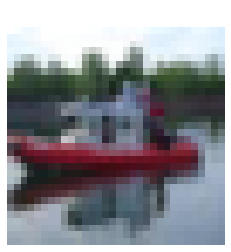

In [44]:
def show_image(img):
    if (isinstance(img, tf.data.Dataset)):
        for image, label in img:
            plt.figure(frameon=False, facecolor='white')
            title = class_names[label.numpy()]+" ["+str(label.numpy())+"]"
            plt.title(title, fontdict={'color':'white','size':20})
            plt.imshow(image.numpy())
            plt.axis('off')
    else:
        plt.figure(frameon=False, facecolor='white')
        plt.title("None", fontdict={'color':'white','size':20})
        plt.imshow(img.numpy())
        plt.axis('off')

# Take one image
show_image(labeled_ds.take(1))

### Resampling the dataset to a 50/50 distribution
https://www.tensorflow.org/guide/data#resampling

In [45]:
# Make large batches to be certain a good amount of minority class makes it in
labeled_ds = labeled_ds.batch(1024)

In [46]:
def count(counts, batch):
        images, labels = batch
        
        class_1 = labels == 1
        class_1 = tf.cast(class_1, tf.int32)

        class_0 = labels == 0
        class_0 = tf.cast(class_0, tf.int32)

        counts['class_0'] += tf.reduce_sum(class_0)
        counts['class_1'] += tf.reduce_sum(class_1)

        return counts

In [47]:
counts = labeled_ds.take(10).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

counts_sum = counts.sum()
assert counts_sum != 0, "Can't divide by zero"

fractions = counts/counts_sum
print("Fractions: ", fractions)
print("Counts: ", counts)

Fractions:  [0.10146485 0.89853513]
Counts:  [1039. 9201.]


In [48]:
negative_ds = labeled_ds.unbatch().filter(lambda image, label: label==0).repeat()
positive_ds = labeled_ds.unbatch().filter(lambda image, label: label==1).repeat()

In [49]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

In [50]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 1 1 1 0 1 1 0 0 1]
[0 1 0 1 0 0 0 1 0 0]
[0 0 1 1 0 1 0 1 1 0]
[1 1 1 0 1 0 1 0 0 0]
[0 0 1 1 0 0 0 1 0 1]
[0 1 1 0 0 0 0 0 1 1]
[1 0 0 1 0 0 0 0 0 1]
[0 1 0 0 1 0 0 1 1 0]
[1 1 0 1 1 0 1 1 0 0]
[1 0 1 0 0 1 1 1 0 0]


In [51]:
# Verify that it has been resampled
counts = balanced_ds.take(30).reduce(
        initial_state={'class_0': 0, 'class_1': 0},
        reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

print(counts/counts.sum())

[0.50333333 0.49666667]


### Splitting into training, test and validation data

In [52]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = balanced_ds.unbatch()#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [53]:
# Print info about the dataset split
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:           -2
Train dataset sample size:          -2
Test dataset sample size:           -2
Validation dataset sample size:     -2


In [54]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/{}_train.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/{}_test.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/{}_val.tfcache".format(IMG_WIDTH))

# Training

### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [55]:
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [56]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [57]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

In [58]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/normal_cnn', update_freq='batch')]

In [59]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

Train for 546 steps, validate for 117 steps
Epoch 1/5
546/546 [==============================] - 4s 7ms/step - loss: 0.2999 - accuracy: 0.8777 - val_loss: 0.2560 - val_accuracy: 0.8946
Epoch 2/5
546/546 [==============================] - 3s 6ms/step - loss: 0.1772 - accuracy: 0.9288 - val_loss: 0.3829 - val_accuracy: 0.8530
Epoch 3/5
546/546 [==============================] - 3s 6ms/step - loss: 0.1219 - accuracy: 0.9550 - val_loss: 0.2973 - val_accuracy: 0.8839
Epoch 4/5
546/546 [==============================] - 3s 6ms/step - loss: 0.0928 - accuracy: 0.9658 - val_loss: 0.0973 - val_accuracy: 0.9650
Epoch 5/5
546/546 [==============================] - 3s 6ms/step - loss: 0.0692 - accuracy: 0.9742 - val_loss: 0.1128 - val_accuracy: 0.9595


`Keras`
Save/load the model

In [27]:
cnn_model.save('models/{}.h5'.format(model_name))
# tl_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

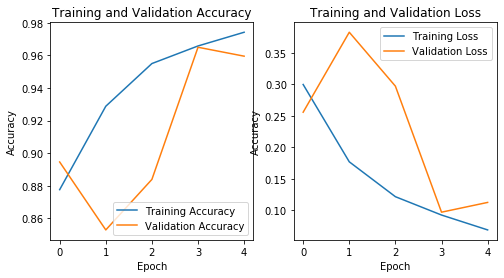

117/117 - 20s - loss: 9.5307 - accuracy: 0.0373


In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 4))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=val_size//BATCH_SIZE)

`Tensorboard`

In [29]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [30]:
# !kill 20058

## Predict new samples

In [61]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

Image 49 of 64


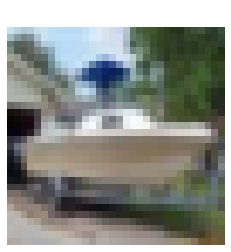

In [66]:
# Get a random image and label
idx = np.random.randint(0, BATCH_SIZE)
image = images[idx]
label = labels[idx]

# Predict one image
result = cnn_model.predict(np.expand_dims(image, axis=0))[0][0]

pred = ('Boat') if result<0.5 else ('Not boat')

print ("Image {} of {}".format(idx,BATCH_SIZE))
# print ("True label:", class_names[label])
# print ('Probabibity of Negative: {:.5f}%'.format((result)*100))

plt.figure(frameon=False, facecolor='white');
plt.title(pred, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [63]:
# Predict one batch
results = cnn_model.predict(images)

print ('{:3}  {:7}  {:3}%'.format('idx', 'true_label', 'pred_prob'))
print ('---  ---------   ----------')
idx = 0
for result in results:
    true_label = class_names[labels[idx]]
    pred_prob = result[0]*100
    print ('{:3}  {:10}  {:05f}%'.format(idx, true_label, pred_prob))
    idx += 1

idx  true_label  pred_prob%
---  ---------   ----------
  0  Positive    99.999714%
  1  Positive    100.000000%
  2  Positive    99.999833%
  3  Positive    95.645577%
  4  Positive    100.000000%
  5  Negative    0.479495%
  6  Negative    0.558425%
  7  Negative    8.456659%
  8  Positive    100.000000%
  9  Negative    7.932175%
 10  Positive    100.000000%
 11  Negative    0.600226%
 12  Negative    0.129768%
 13  Negative    40.121943%
 14  Positive    99.996269%
 15  Positive    100.000000%
 16  Positive    99.998665%
 17  Positive    100.000000%
 18  Positive    99.999988%
 19  Positive    99.997568%
 20  Negative    5.319447%
 21  Positive    99.999928%
 22  Negative    0.044691%
 23  Negative    3.271003%
 24  Positive    100.000000%
 25  Positive    100.000000%
 26  Negative    6.066957%
 27  Negative    1.999377%
 28  Negative    0.721849%
 29  Negative    0.039078%
 30  Negative    3.855901%
 31  Negative    0.001380%
 32  Positive    100.000000%
 33  Negative    1.478924%